<a href="https://colab.research.google.com/github/dafarren/Price-and-Inventory-Policy-Model/blob/main/synthetic_data_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmhyc8bcw/91_lebjd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmhyc8bcw/gwwgahl1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7271', 'data', 'file=/tmp/tmpmhyc8bcw/91_lebjd.json', 'init=/tmp/tmpmhyc8bcw/gwwgahl1.json', 'output', 'file=/tmp/tmpmhyc8bcw/prophet_modelu33gnvm5/prophet_model-20250201120458.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:04:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:04:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 3.97, MSE: 24.92, R²: 0.99
Elasticidad Precio de la Demanda Estimada: -1.00
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     87.77
Date:                Sat, 01 Feb 2025   Prob (F-statistic):           3.84e-18
Time:                        12:04:58   Log-Likelihood:                 136.07
No. Observations:                 260   AIC:                            -268.1
Df Residuals:                     258   BIC:                            -261.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

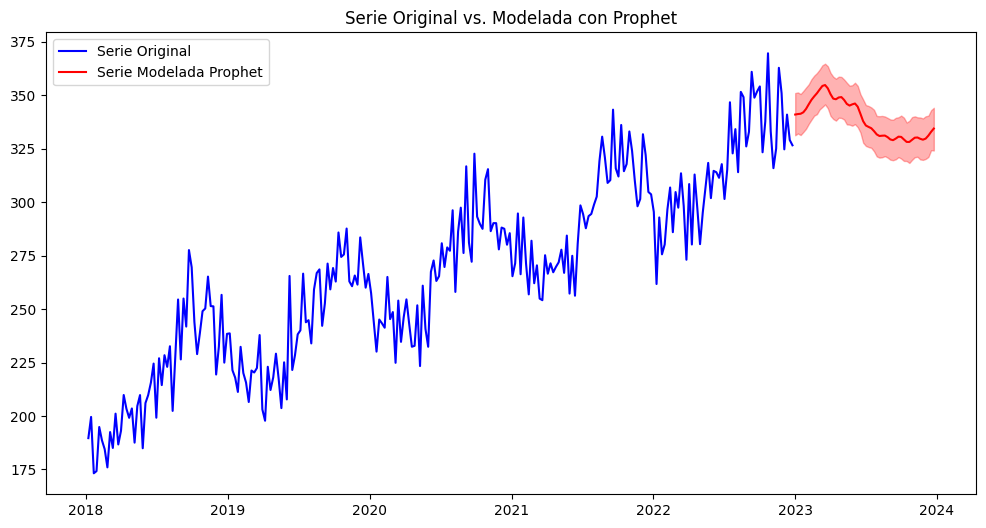

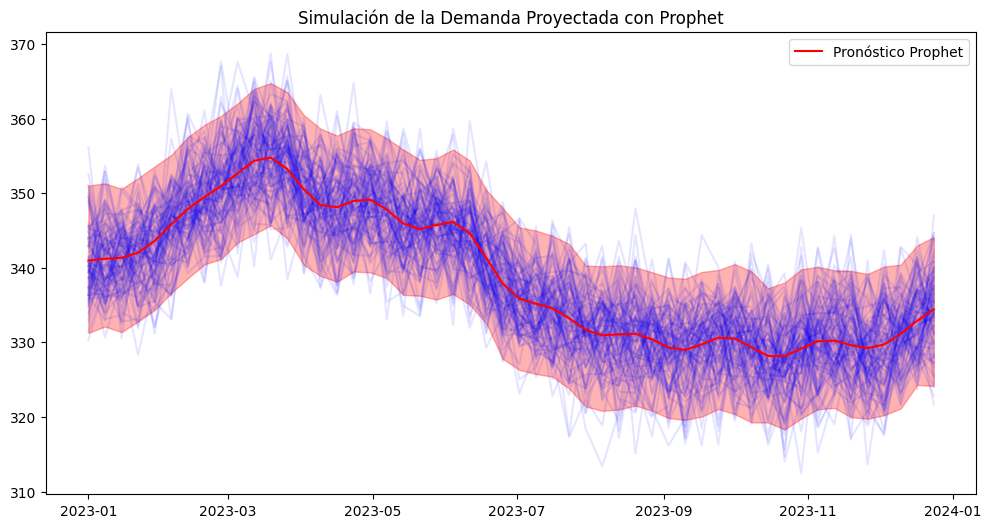

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Intentar importar Prophet, manejar errores si no está disponible
try:
    from prophet import Prophet
except ImportError:
    raise ImportError("El paquete 'prophet' no está instalado. Instálalo con '!pip install prophet'")

# Definir Elasticidad Precio de la Demanda como un parámetro
elasticity = -1.5  # Ajusta este valor según el tipo de producto

# Generar datos sintéticos
np.random.seed(42)
n_weeks = 5 * 52  # 5 años de datos semanales
time = np.arange(n_weeks)

# Generar precios fluctuantes
prices = 50 + 5 * np.sin(2 * np.pi * time / 52) + np.random.normal(scale=2, size=n_weeks)

# Precio base y demanda base
P0 = np.mean(prices)
Q0 = 200  # Demanda base en el precio medio

# Generar demanda con elasticidad precio de la demanda
sales = Q0 * (prices / P0) ** elasticity

# Agregar tendencia, estacionalidad y ruido
trend = 0.5 * time
seasonality = 10 * np.sin(2 * np.pi * time / 52)
random_noise = np.random.normal(scale=5, size=n_weeks)
sales += trend + seasonality + random_noise

df = pd.DataFrame({'week': pd.date_range(start='2018-01-01', periods=n_weeks, freq='W'), 'sales': sales, 'price': prices})

# Modelado con Prophet
df_prophet = df.rename(columns={'week': 'ds', 'sales': 'y'})
prophet_model = Prophet(interval_width=0.95)
prophet_model.add_regressor('price')
prophet_model.fit(df_prophet)

# Evaluación del modelo
forecast_train = prophet_model.predict(df_prophet)
y_true = df_prophet['y']
y_pred = forecast_train['yhat']
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, R²: {r2:.2f}")

# Calcular Elasticidad Precio de la Demanda (EPD) a partir de los datos
log_prices = np.log(df_prophet['price'])
log_sales = np.log(df_prophet['y'])
X = sm.add_constant(log_prices)
model = sm.OLS(log_sales, X).fit()
calculated_elasticity = model.params['price']
print(f"Elasticidad Precio de la Demanda Estimada: {calculated_elasticity:.2f}")
print(model.summary())

# Crear futuro con precios proyectados
future = prophet_model.make_future_dataframe(periods=52, freq='W')
future_prices_only = np.linspace(prices[-1] * 0.95, prices[-1] * 1.05, 52)  # Simular variaciones en los precios
future.loc[future.index[-52:], 'price'] = future_prices_only  # Asignar precios solo a filas futuras
forecast = prophet_model.predict(future.dropna())

# Visualización de la serie original y modelada
plt.figure(figsize=(12, 6))
plt.plot(df['week'], df['sales'], label="Serie Original", color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label="Serie Modelada Prophet", color='red')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.3)
plt.title("Serie Original vs. Modelada con Prophet")
plt.legend()
plt.show()

# Simulación de demanda proyectada con Prophet
def simulate_demand(model, future, simulations=100):
    future_only = future.iloc[-52:].copy()
    simulations_results = np.zeros((simulations, len(future_only)))
    for i in range(simulations):
        forecast_sim = model.predict(future_only)['yhat'] + np.random.normal(scale=5, size=len(future_only))
        simulations_results[i, :] = forecast_sim
    return simulations_results

simulated_demand = simulate_demand(prophet_model, future, simulations=100)

# Visualización de simulaciones
plt.figure(figsize=(12, 6))
plt.plot(forecast['ds'], simulated_demand.T, alpha=0.1, color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label="Pronóstico Prophet", color='red')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.3)
plt.title("Simulación de la Demanda Proyectada con Prophet")
plt.legend()
plt.show()


Entrenando...: 100%|██████████| 5000/5000 [07:04<00:00, 11.77it/s]


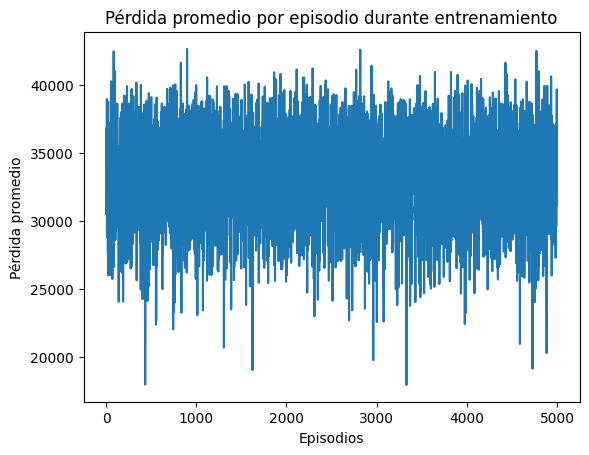

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
from tqdm import tqdm
import matplotlib.pyplot as plt

# Parámetros del problema
L = 4  # Lead time en semanas
K = 100  # Costo fijo de orden
h = 10   # Costo de mantenimiento por unidad
b = 5    # Costo de escasez por unidad
T = 52   # Horizonte de evaluación en semanas
I0 = 100  # Inventario inicial
I_max = 500  # Inventario máximo
service_level = 0.95  # Nivel de servicio
C = 80  # Costo de compra por unidad
elasticity = -1.5  # Elasticidad precio-demanda

def generate_demand(prices):
    P0 = np.mean(prices)
    if np.isnan(P0) or P0 == 0:
        P0 = 1  # Evitar división por cero o nan
    Q0 = 200  # Demanda base
    sales = Q0 * (prices / P0) ** elasticity
    trend = 0.5 * np.arange(len(prices))
    seasonality = 10 * np.sin(2 * np.pi * np.arange(len(prices)) / 52)
    random_noise = np.random.normal(scale=5, size=len(prices))
    sales += trend + seasonality + random_noise
    return np.maximum(sales, 0)  # Asegurar que no haya demanda negativa

class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(5, 32)  # Modificado para incluir más entradas
        self.fc2 = nn.Linear(32, 32)
        self.fc3_price = nn.Linear(32, 2)  # Media y desviación del precio
        self.fc3_order = nn.Linear(32, 2)  # Media y desviación del tamaño del pedido

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        price_params = self.fc3_price(x)
        order_params = self.fc3_order(x)
        return price_params, order_params

def train_policy_gradient(epochs=5000, gamma=0.99, lr=0.01):
    policy_net = PolicyNetwork()
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    loss_history = []

    for epoch in tqdm(range(epochs), desc='Entrenando...'):
        inventory = I0
        order_queue = [0] * L  # Cola de pedidos pendientes por lead time
        prev_price = C  # Precio inicial
        avg_demand = 200  # Demanda promedio inicial
        states, log_probs, rewards = [], [], []

        for t in range(T):
            inventory += order_queue.pop(0)  # Recibir pedidos con retraso
            state_values = [inventory, t / T, prev_price, avg_demand, sum(order_queue) / L]
            state = torch.tensor(state_values, dtype=torch.float32)

            if torch.isnan(state).any():
                continue  # Evita entrenar con estados inválidos

            price_params, order_params = policy_net(state)

            price_mean = torch.clamp(price_params[0], min=1.0, max=200.0)  # Asegurar valores realistas
            order_mean = torch.clamp(order_params[0], min=0.0, max=I_max)

            price_std = torch.exp(torch.clamp(price_params[1], min=-2, max=2))  # Evitar valores extremos
            order_std = torch.exp(torch.clamp(order_params[1], min=-2, max=2))

            price_dist = Normal(price_mean, price_std)
            order_dist = Normal(order_mean, order_std)

            price = price_dist.sample()
            order = torch.clamp(order_dist.sample(), min=0, max=I_max - inventory)

            log_prob_price = price_dist.log_prob(price)
            log_prob_order = order_dist.log_prob(order)

            demand = generate_demand([price.item()])[0]
            sales = min(inventory, demand)
            inventory = max(0, inventory - sales)

            order_queue.append(order.item())  # Agregar pedido a la cola
            prev_price = price.item()
            avg_demand = 0.9 * avg_demand + 0.1 * demand  # Actualizar demanda promedio

            revenue = sales * price.item()
            ordering_cost = K if order.item() > 0 else 0 + C * order.item()
            holding_cost = h * inventory
            shortage_cost = b * max(0, demand - sales)

            reward = revenue - (ordering_cost + holding_cost + shortage_cost)

            states.append(state)
            log_probs.append(log_prob_price + log_prob_order)  # Suma de log-probabilidades
            rewards.append(reward)

        if len(rewards) == 0:
            continue  # Evita actualizar con episodios vacíos

        discounted_rewards = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            discounted_rewards.insert(0, G)

        discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32)
        loss = -sum([discounted_rewards[i] * log_probs[i] for i in range(len(rewards))]) / len(rewards)  # Normalización

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

    return policy_net, loss_history

policy, loss_history = train_policy_gradient()

plt.plot(loss_history)
plt.title('Pérdida promedio por episodio durante entrenamiento')
plt.xlabel('Episodios')
plt.ylabel('Pérdida promedio')
plt.show()


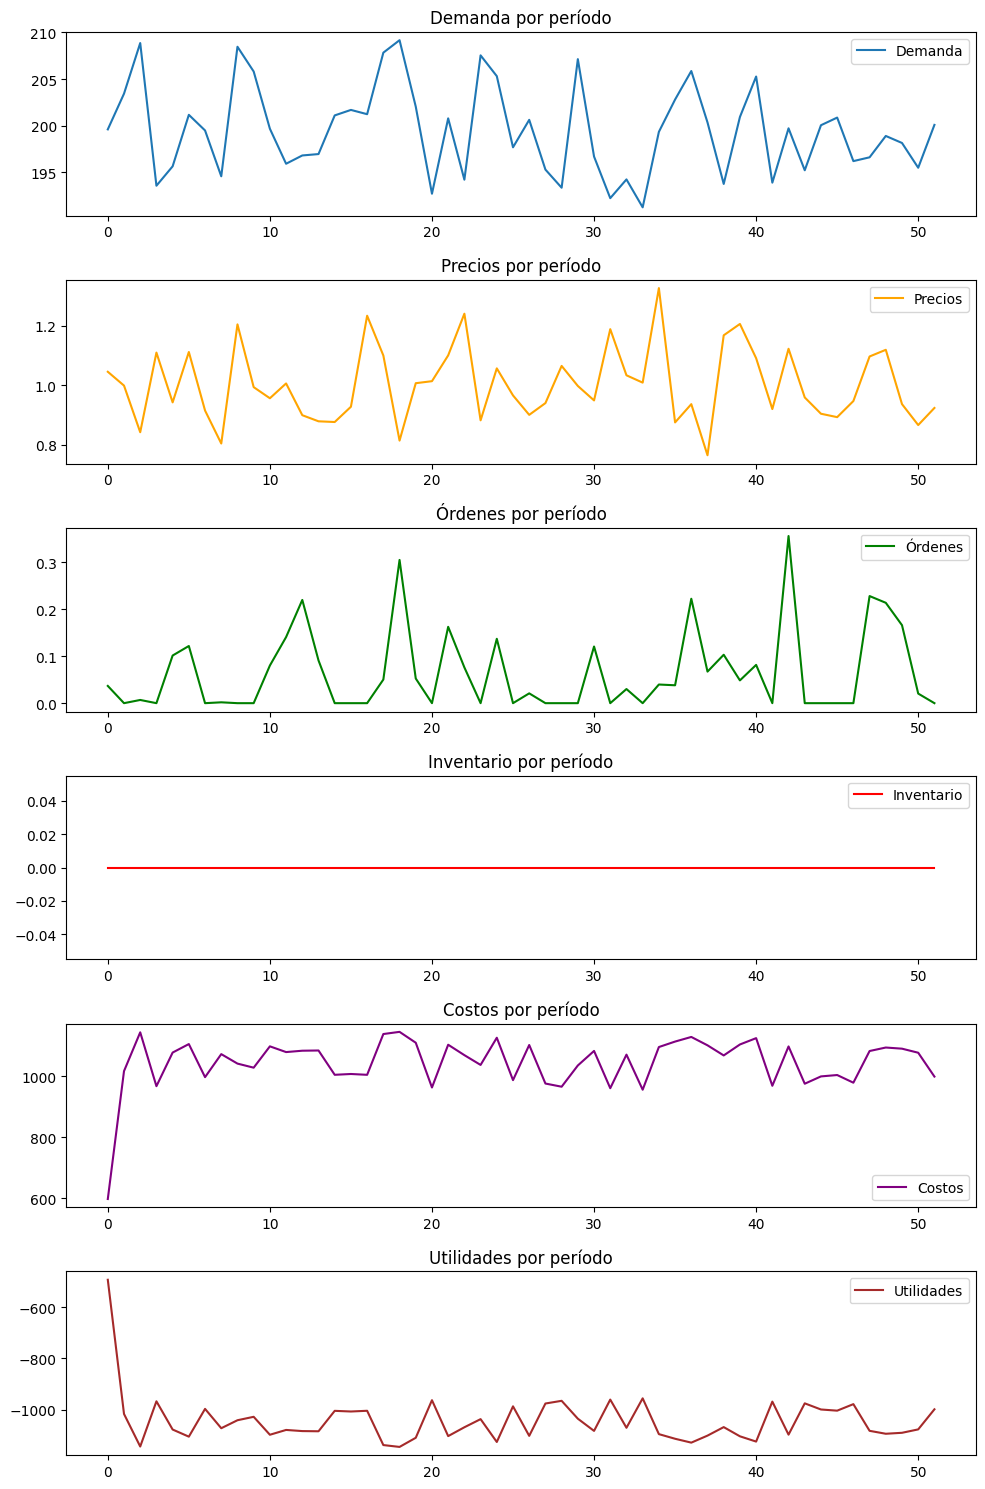

In [ ]:
# Simulación de la política óptima
inventory = I0
order_queue = [0] * L
hist_demand, hist_prices, hist_orders, hist_inventory, hist_costs, hist_profits = [], [], [], [], [], []

for t in range(T):
    inventory += order_queue.pop(0)
    state_values = [inventory, t / T, C, 200, sum(order_queue) / L]
    state = torch.tensor(state_values, dtype=torch.float32)
    price_params, order_params = policy(state)

    price_mean = torch.clamp(price_params[0], min=1.0, max=200.0)
    order_mean = torch.clamp(order_params[0], min=0.0, max=I_max)

    price_std = torch.exp(torch.clamp(price_params[1], min=-2, max=2))
    order_std = torch.exp(torch.clamp(order_params[1], min=-2, max=2))

    price_dist = Normal(price_mean, price_std)
    order_dist = Normal(order_mean, order_std)

    price = price_dist.sample()
    order = torch.clamp(order_dist.sample(), min=0, max=I_max - inventory)

    demand = generate_demand([price.item()])[0]
    sales = min(inventory, demand)
    inventory = max(0, inventory - sales)

    order_queue.append(order.item())

    revenue = sales * price.item()
    ordering_cost = K if order.item() > 0 else 0 + C * order.item()
    holding_cost = h * inventory
    shortage_cost = b * max(0, demand - sales)
    total_cost = ordering_cost + holding_cost + shortage_cost
    profit = revenue - total_cost

    hist_demand.append(demand)
    hist_prices.append(price.item())
    hist_orders.append(order.item())
    hist_inventory.append(inventory)
    hist_costs.append(total_cost)
    hist_profits.append(profit)

# Gráficos
fig, axes = plt.subplots(6, 1, figsize=(10, 15))
axes[0].plot(hist_demand, label='Demanda')
axes[0].set_title('Demanda por período')
axes[0].legend()

axes[1].plot(hist_prices, label='Precios', color='orange')
axes[1].set_title('Precios por período')
axes[1].legend()

axes[2].plot(hist_orders, label='Órdenes', color='green')
axes[2].set_title('Órdenes por período')
axes[2].legend()

axes[3].plot(hist_inventory, label='Inventario', color='red')
axes[3].set_title('Inventario por período')
axes[3].legend()

axes[4].plot(hist_costs, label='Costos', color='purple')
axes[4].set_title('Costos por período')
axes[4].legend()

axes[5].plot(hist_profits, label='Utilidades', color='brown')
axes[5].set_title('Utilidades por período')
axes[5].legend()

plt.tight_layout()
plt.show()

In [ ]:
prices

array([50.99342831, 50.3261548 , 52.4919554 , 54.81908415, 51.85530911,
       52.37204982, 56.47403892, 55.2774232 , 53.17597056, 55.51240022,
       53.74824583, 53.92324958, 55.44746891, 51.17343951, 51.51370871,
       53.73013403, 52.64941897, 55.05577479, 52.29887118, 50.91794634,
       56.24691083, 52.38877113, 52.45867227, 48.92352806, 50.10781287,
       50.82452858, 47.69801285, 50.14871264, 47.6021443 , 47.64358807,
       46.47297092, 50.86423264, 46.65739226, 44.1420244 , 47.53017049,
       43.13103257, 45.74264598, 41.22595067, 42.38008353, 45.39372247,
       46.51338879, 45.48802748, 45.09362222, 44.97051248, 42.92803669,
       44.81775784, 45.76310917, 49.27392072, 48.36362072, 44.70089525,
       49.45158962, 48.62715204])

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Intentar importar Prophet, manejar errores si no está disponible
try:
    from prophet import Prophet
except ImportError:
    raise ImportError("El paquete 'prophet' no está instalado. Instálalo con '!pip install prophet'")


def generar_datos_sinteticos(n_years=5, elasticity=-1.5, Q0=200, random_seed=42):
    """
    Genera datos sintéticos de ventas y precios para un producto durante n_years años de datos semanales.

    Parámetros:
        n_years (int): Número de años a generar (cada año tiene 52 semanas). Por defecto 5.
        elasticity (float): Elasticidad precio de la demanda. Por defecto -1.5.
        Q0 (float): Demanda base en el precio medio. Por defecto 200.
        random_seed (int): Semilla para la generación de números aleatorios. Por defecto 42.

    Retorna:
        pd.DataFrame: DataFrame con las columnas 'week' (fechas semanales), 'sales' (ventas) y 'price' (precios).
    """
    # Configurar semilla para reproducibilidad
    np.random.seed(random_seed)

    # Número total de semanas
    n_weeks = n_years * 52
    time = np.arange(n_weeks)

    # Generar precios fluctuantes
    prices = 50 + 5 * np.sin(2 * np.pi * time / 52) + np.random.normal(scale=2, size=n_weeks)

    # Precio base y demanda base
    P0 = np.mean(prices)

    # Generar demanda utilizando la elasticidad
    sales = Q0 * (prices / P0) ** elasticity

    # Agregar tendencia, estacionalidad y ruido aleatorio
    trend = 0.5 * time
    seasonality = 10 * np.sin(2 * np.pi * time / 52)
    random_noise = np.random.normal(scale=5, size=n_weeks)
    sales += trend + seasonality + random_noise

    # Crear DataFrame con fechas semanales
    df = pd.DataFrame({
        'week': pd.date_range(start='2018-01-01', periods=n_weeks, freq='W'),
        'sales': sales,
        'price': prices
    })

    return df

In [5]:
!git clone https://github.com/dafarren/Price-and-Inventory-Policy-Model.git


Cloning into 'Price-and-Inventory-Policy-Model'...
fatal: could not read Username for 'https://github.com': No such device or address
